# ANOVA comparison of model evaluation results

## Import Libraries

In [32]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

from statsmodels.formula.api import ols

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

## Save Plots Switch

In [2]:
save_plots = True

## Import Data to be compared

In [3]:
rfc_data = pd.read_csv('./output_datasets/rfc_datasets/cross_validation_results.csv')
svm_data = pd.read_csv('./output_datasets/svm_datasets/cross_validation_results.csv')
knn_data = pd.read_csv('./output_datasets/knn_datasets/cross_validation_results.csv')

In [4]:
#rfc_data.head()

## Average Columns to produce Round Medians

In [5]:
rfc_class_medians = pd.DataFrame(rfc_data.median(axis=1))

In [6]:
rfc_class_medians.columns = ['f1_score']

In [7]:
rfc_class_medians.insert(0, "ml_method",'RFC')

In [8]:
#rfc_class_medians.head()

In [9]:
svm_class_medians = pd.DataFrame(svm_data.median(axis=1))

In [10]:
svm_class_medians.columns = ['f1_score']

In [11]:
svm_class_medians.insert(0, "ml_method",'SVM')

In [12]:
#svm_class_medians.head()

In [13]:
knn_class_medians = pd.DataFrame(knn_data.median(axis=1))

In [14]:
knn_class_medians.columns = ['f1_score']

In [15]:
knn_class_medians.insert(0, "ml_method",'KNN')

In [67]:
#knn_class_medians.head()

## Merge rfc, svm, knn medians into single df

In [17]:
ml_medians = pd.concat([rfc_class_medians, svm_class_medians, knn_class_medians])

## Visualise median F1 ccores per method

In [90]:
filepath = 'final_figures/ML_Technique_F1s_comparison_boxplot.eps'

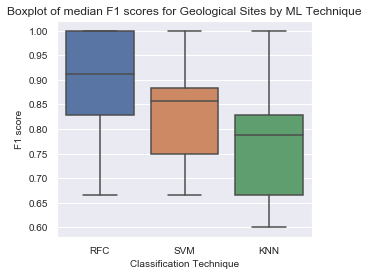

In [91]:
sns.set(rc={'figure.figsize':(5,4)})
plot = sns.boxplot(x = ml_medians['ml_method'], y = ml_medians['f1_score'])

plot.set_title('Boxplot of median F1 scores for Geological Sites by ML Technique', fontdict={'fontsize': 12})

plot.set_ylabel('F1 score', fontdict={'fontsize': 10})
plot.set_xlabel("Classification Technique", fontdict={'fontsize': 10})

plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.tight_layout()

if save_plots:
    fig = plot.get_figure()
    fig.savefig(fname=filepath, dpi = 2000, pad_inches = 0.5, bbox_extra_artists=(plot,), bbox_inches='tight')

## Conduct ANOVA

In [175]:
lm = ols('f1_score ~ ml_method',data=ml_medians).fit()
anova_table = sm.stats.anova_lm(lm)
print(anova_table)

             df    sum_sq   mean_sq         F    PR(>F)
ml_method   2.0  0.163310  0.081655  6.815376  0.002481
Residual   48.0  0.575086  0.011981       NaN       NaN


In [174]:
"""
From - https://www.pythonfordatascience.org/anova-python/
The function below was created specifically for the one-way ANOVA table results 
returned for Type II sum of squares.

"""

def anova_table(anova):
    anova['mean_sq'] = anova[:]['sum_sq']/anova[:]['df']
    anova['eta_sq'] = anova[:-1]['sum_sq']/sum(anova['sum_sq'])
    anova['omega_sq'] = (anova[:-1]['sum_sq']-(anova[:-1]['df']*anova['mean_sq'][-1]))/(sum(anova['sum_sq'])+anova['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    anova = anova[cols]
    return anova

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
ml_method,0.163310,2.0,0.081655,6.815376,0.002481,0.221168,0.185704
Residual,0.575086,48.0,0.011981,NaN,NaN,NaN,NaN


In [ ]:
"""
F statistic and p-value above demonstrate there is a significant 
difference between the groups.
"""

## Post-Hoc tests

### Test for Normality

In [161]:
stats.shapiro(lm.resid) #W-test statistic, p-value

(0.972887396812439, 0.29040753841400146)

In [164]:
filepath = 'final_figures/Probability_Plot.eps'

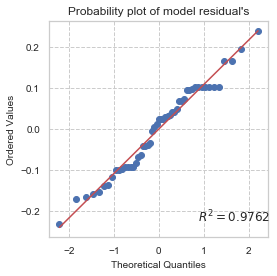

In [171]:
sns.set_style("whitegrid",{'grid.linestyle': 'dashed'})
fig = plt.figure(figsize= (4, 4))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(lm.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 12)
ax.set

ax.set_xlabel('Theoretical Quantiles',fontsize=10)
ax.set_ylabel('Ordered Values',fontsize=10)

plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.tight_layout()

plt.show()

if save_plots:
    #fig = plt.get_figure()
    fig.savefig(fname=filepath, dpi = 2000, pad_inches = 0.5, bbox_extra_artists=(plot,), bbox_inches='tight')

In [ ]:
""" 
Rsq value (0.9762) > 0.05 value (0.9753), therefore we cannot reject the 
null hypothesis that the data came from a population with a normal distribution. 

""" 

### Levene's test of homogeneity

In [36]:
stats.levene(ml_medians['f1_score'][ml_medians['ml_method'] == 'RFC'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'SVM'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'KNN'])

LeveneResult(statistic=0.4285340906398199, pvalue=0.6539311766926287)

In [ ]:
"""
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm

p-value (0.65) is not below 0.05, therefore we cannot reject the null hypothesis that 
we don't have equality of variance.

"""

In [172]:
filepath = 'final_figures/Levenes_Boxplot.eps'

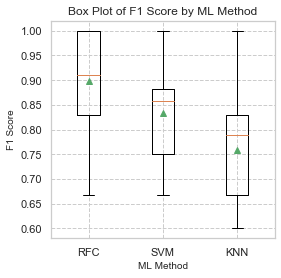

In [173]:
fig = plt.figure(figsize= (4, 4))
sns.set_style("whitegrid",{'grid.linestyle': 'dashed'})

plot = fig.add_subplot(111)

plot.set_title('Box Plot of F1 Score by ML Method', fontsize= 12)
plot.set

data = [ml_medians['f1_score'][ml_medians['ml_method'] == 'RFC'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'SVM'],
             ml_medians['f1_score'][ml_medians['ml_method'] == 'KNN']]

plot.boxplot(data, labels= ['RFC', 'SVM', 'KNN'], showmeans= True)

plt.xlabel('ML Method',fontsize=10)
plt.ylabel('F1 Score',fontsize=10)

plt.show()

if save_plots:
    fig = plot.get_figure()
    fig.savefig(fname=filepath, dpi = 2000, pad_inches = 0.5, bbox_extra_artists=(plot,), bbox_inches='tight')

In [ ]:
"""
Boxplots visually support idea that groups have equal variance.
"""

### Tukey's HSD (Honestly Significant Difference)

In [39]:
comparison = mc.MultiComparison(ml_medians['f1_score'], ml_medians['ml_method'])
post_hoc_res = comparison.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
KNN,RFC,0.1385,0.0016,0.0477,0.2293,True
KNN,SVM,0.0738,0.1319,-0.017,0.1646,False
RFC,SVM,-0.0647,0.2068,-0.1555,0.0261,False


In [118]:
filepath = 'final_figures/Tukey_Comparison_Between_Methods.eps'

<Figure size 288x288 with 0 Axes>

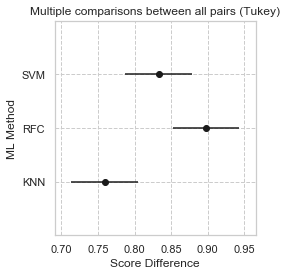

In [160]:
sns.set_style("whitegrid",{'grid.linestyle': 'dashed'})
fig = plt.figure(figsize= (4, 4))

plot = post_hoc_res.plot_simultaneous(ylabel= 'ML Method', xlabel= 'Score Difference', figsize=(4,4))

plt.title('Multiple comparisons between all pairs (Tukey)', fontsize=12)

plt.tight_layout()

if save_plots:
    fig = plot.get_figure()
    plot.savefig(fname=filepath, dpi = 2000, pad_inches = 0.5, bbox_extra_artists=(plot,), bbox_inches='tight')

### Bonferroni Correction

In [43]:
comparison = mc.MultiComparison(ml_medians['f1_score'], ml_medians['ml_method'])
table, a1, a2 = comparison.allpairtest(stats.ttest_ind, method= 'bonf')

table

group1,group2,stat,pval,pval_corr,reject
KNN,RFC,-3.5358,0.0013,0.0038,True
KNN,SVM,-1.9562,0.0592,0.1776,False
RFC,SVM,1.8154,0.0788,0.2365,False


### Dunn-Sidak Correction

In [177]:
comparison = mc.MultiComparison(ml_medians['f1_score'], ml_medians['ml_method'])
table, a1, a2 = comparison.allpairtest(stats.ttest_ind, method= 'sidak')

table

group1,group2,stat,pval,pval_corr,reject
KNN,RFC,-3.5358,0.0013,0.0038,True
KNN,SVM,-1.9562,0.0592,0.1673,False
RFC,SVM,1.8154,0.0788,0.2184,False
